### Load and preprocess the data
Load and preprocess the dataset, which includes splitting it into training and test sets and performing standard scaling.

In [22]:
import numpy as np
import pandas as pd
train=pd.read_csv('IndoreHP_Train.csv')
test=pd.read_csv('IndoreHP_Test.csv')

X=train.drop(columns=['MEDV'])
y=train['MEDV']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=42)


from sklearn.preprocessing import MinMaxScaler
# Perform Min-Max scaling on the features
scaler = MinMaxScaler(feature_range=(0,1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
test=scaler.transform(test)

### Dimensionality Reduction with PCA

Perform dimensionality reduction with PCA on the training data. This step reduces the high-dimensional feature space to a lower-dimensional representation while retaining the most important information.

Calculate the explained variance ratio and cumulative variance. The explained variance ratio indicates the amount of variance explained by each principal component, while the cumulative variance represents the total amount of variance explained cumulatively.

Plot the scree plot, which shows the cumulative explained variance ratio for each number of dimensions. This plot helps visualize the amount of variance captured by different numbers of dimensions.

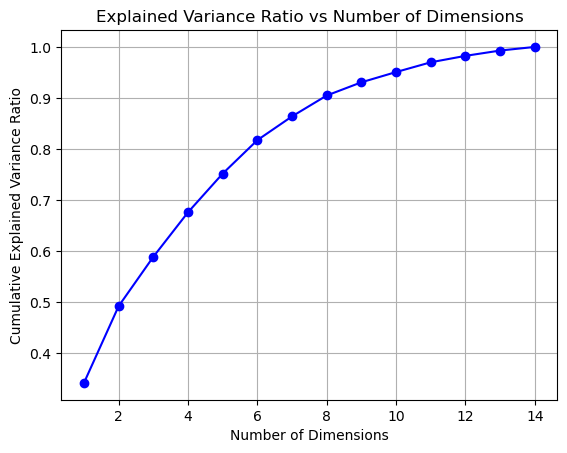

In [23]:

from sklearn.decomposition import PCA
pca = PCA()
X_train_pca = pca.fit_transform(X_train)

import matplotlib.pyplot as plt

#Calculate explained variance ratio and plot it
explained_variance=pca.explained_variance_ratio_
cumulative_variance=np.cumsum(explained_variance)

# plot the SCREE plot
plt.plot(range(1,len(cumulative_variance)+1),
         cumulative_variance, 'bo-')
plt.xlabel('Number of Dimensions')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance Ratio vs Number of Dimensions')
plt.grid(True)
plt.show()

Determine the optimal number of dimensions based on the desired variance threshold (90% in this case). The code finds the index of the first value in the cumulative variance that exceeds the desired threshold and selects the corresponding number of dimensions.

In [24]:
desired_variance = 0.9
num_dimensions = np.argmax(cumulative_variance >= desired_variance) + 1
print("Number of dimensions to capture {}% of the variance: {}".format(int(desired_variance * 100), num_dimensions))

Number of dimensions to capture 90% of the variance: 8


Perform dimensionality reduction with PCA on both the training and unseen (test) data using the optimal number of dimensions obtained in the previous step. This ensures consistency in feature selection between the training and test sets.

t-SNE (t-Distributed Stochastic Neighbor Embedding) is primarily used for visualization purposes and is not typically employed as a dimensionality reduction technique for further modeling or analysis. It is effective at capturing local structure and non-linear relationships in high-dimensional data, which makes it useful for visualizing clusters or patterns.

In [26]:

# Perform dimensionality reduction with PCA on both training and unseen data
X_train_reduced = X_train_pca[:, :num_dimensions]
X_test_reduced = pca.transform(X_test)[:, :num_dimensions]
test=pca.transform(test)[:,:num_dimensions]

### Apply Huber regression

Apply Huber regression, a robust regression algorithm, to the reduced training data. Huber regression is used to model the relationship between the reduced features and the target variable.

Predict the target variable for the reduced test data using the trained Huber regression model.

Evaluate the model's performance by calculating metrics such as Mean Absolute Error (MAE), Mean Squared Error (MSE), and R-squared. These metrics provide insights into the accuracy and goodness of fit of the regression model.

In [27]:
from sklearn.linear_model import HuberRegressor
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error

huber = HuberRegressor()
huber.fit(X_train_reduced, y_train)
y_pred = huber.predict(X_test_reduced)

# Step 9: Evaluate the model's performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Absolute Error: 3.098417909819981
Mean Squared Error: 18.08736500141772
R-squared: 0.7538961412272267


### Perform Hyperparameter tuning on the Huber Regressor with Cross Validation

Alpha represents the regularization strength in the HuberRegressor algorithm. It applies an L1 regularization penalty to the coefficient estimates, similar to the Lasso regression. Higher values of alpha result in stronger regularization, effectively shrinking the coefficient estimates towards zero and potentially reducing overfitting.

In the Huber loss function, epsilon determines the threshold for switching between the squared loss (MSE) and the absolute loss (MAE). Smaller values of epsilon make the HuberRegressor behave more like ordinary least squares (OLS) regression, as it will primarily use the squared loss. Larger values of epsilon emphasize the absolute loss, making the algorithm more robust to outliers.

In [48]:
param_space = {
    'epsilon': [1.0, 1.5, 2.0],
    'alpha': [0.0001, 0.001, 0.01, 0.1]
}

from skopt import BayesSearchCV
# Perform hyperparameter tuning with Bayesian optimization
huber = HuberRegressor()
huber_opt = BayesSearchCV(huber, param_space, \
                          scoring='neg_mean_squared_error', n_iter=100, cv=5)

In [49]:
# Wrap BayesSearchCV with tqdm
from tqdm import tqdm
with tqdm(total=huber_opt.total_iterations, desc='Optimizing') as pbar:
    def callback(res):
        pbar.update(1)

    huber_opt.fit(X_train_reduced, y_train, callback=callback)

Optimizing:   6%|▌         | 12/200 [00:01<00:37,  5.04it/s]/home/ogre/miniconda3/envs/py39/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
Optimizing:   8%|▊         | 15/200 [00:03<00:57,  3.20it/s]/home/ogre/miniconda3/envs/py39/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
Optimizing:   8%|▊         | 16/200 [00:03<01:07,  2.71it/s]/home/ogre/miniconda3/envs/py39/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
Optimizing:   8%|▊         | 17/200 [00:04<01:16,  2.38it/s]/home/ogre/miniconda3/envs/py39/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objecti

In [50]:
# Get the best estimator and make predictions
huber_best = huber_opt.best_estimator_
huber_pred = huber_best.predict(X_test_reduced)
huber_mse = mean_squared_error(y_test, huber_pred)
huber_r2 = r2_score(y_test, huber_pred)
huber_mae = mean_absolute_error(y_test, huber_pred)

# Print results
print("Huber Regression (with Bayesian Optimization):")
print("Best Parameters:", huber_opt.best_params_)
print("Mean Squared Error:", huber_mse)
print("R^2 Score:", huber_r2)
print("MAE:", mae)

Huber Regression (with Bayesian Optimization):
Best Parameters: OrderedDict([('alpha', 0.0001), ('epsilon', 2.0)])
Mean Squared Error: 16.735296014314013
R^2 Score: 0.7722929278806245
MAE: 3.0171095348194736
